# Titanic Survivors -- Data Analysis 

In [1]:
from IPython.core.display import Image
import pandas as pd 
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import statsmodels.api as st
import sklearn
from sklearn import linear_model as lm
from sklearn import cross_validation, preprocessing
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
import matplotlib.patheffects as path_effects
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
print 'Cross-sectional drawing showing ice penetrating the double bottom of the Titanic.'
Image(url='http://bit.ly/29YeBu8', width=350)

Cross-sectional drawing showing ice penetrating the double bottom of the Titanic.


## Aquire the Data

In [3]:
## !psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
## password: gastudents

#### Connect to the remote database

In [4]:
## my_lil_engine = create_engine('postgresql://\
## dsi_student:gastudents@dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com/titanic')
## df = pd.read_sql('SELECT * FROM train', my_lil_engine)
## df.to_csv('titanic_rough.csv', encoding='utf-8')

Run this cell to load the dataframe obtained directly above:

In [5]:
titanic_orig = pd.read_csv('titanic_rough.csv')
titanic = titanic_orig[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex',
       'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
print '_-_-_ Dataframe Info _-_-_ \n'
print 'Data type: %s \n' %type(titanic)
print 'Length: %s \n' %len(titanic)
print 'Column data types: \n\n%s' %titanic.dtypes

_-_-_ Dataframe Info _-_-_ 

Data type: <class 'pandas.core.frame.DataFrame'> 

Length: 891 

Column data types: 

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [6]:
titanic.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [7]:
len(titanic)

891

In [8]:
titanic['Sex'].value_counts() # convert this to binary

male      577
female    314
Name: Sex, dtype: int64

In [7]:
titanic['Survived'].value_counts() # convert this to binary; will be target variable

0    549
1    342
Name: Survived, dtype: int64

In [6]:
titanic['Pclass'].value_counts() # a ranked categorical; getting dummies loses ranked aspect

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [9]:
missing_ages = len(titanic) - len(titanic[titanic['Age'] > 0])
perc = (len(titanic) - len(titanic[titanic['Age'] > 0])) / float(len(titanic))
print 'There are %s age values missing from the dataframe' %missing_ages + ' (%s percent).' \
%(round(perc, 3)*100)

There are 177 age values missing from the dataframe (19.9 percent).


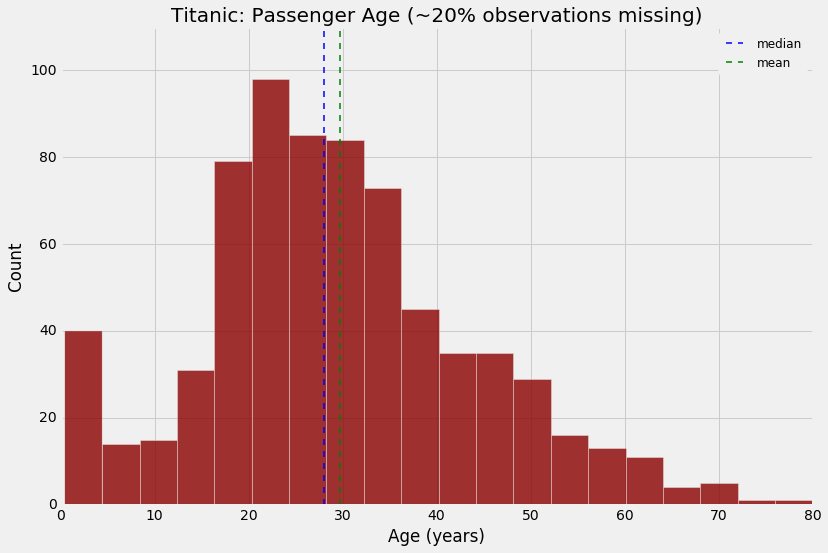

In [13]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

titanic_age = titanic[titanic['Age'] > -0.1]
age_hist = plt.hist(titanic_age['Age'], color = 'darkred', alpha = 0.8, bins = 20)
plt.axvline(titanic_age['Age'].median(), color='b', linestyle='dashed', linewidth=1.5, \
            label = 'median')
plt.axvline(titanic_age['Age'].mean(), color='g', linestyle='dashed', linewidth=1.5, \
            label = 'mean')

plt.title('Titanic: Passenger Age (~20% observations missing)', fontsize = 20)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Age (years)')

plt.xlim([0, max(titanic_age['Age'])])
plt.ylim([0, 110])

plt.legend(loc='upper right', fontsize = 12)

plt.show()

In [14]:
titanic['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

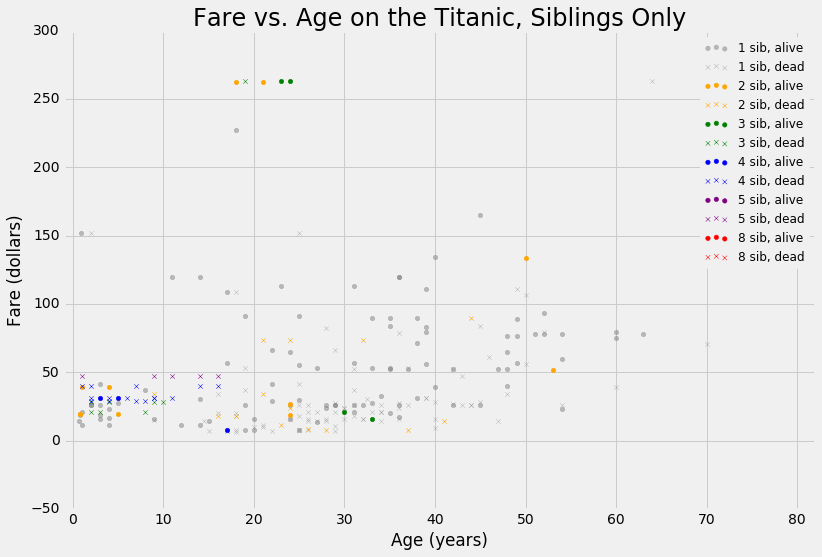

In [15]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

#area = titanic['fare'] 
titanic_sibling = titanic[titanic['SibSp'] > 0]
sib1 = titanic_sibling[titanic_sibling['SibSp'] == 1]
sib2 = titanic_sibling[titanic_sibling['SibSp'] == 2]
sib3 = titanic_sibling[titanic_sibling['SibSp'] == 3]
sib4 = titanic_sibling[titanic_sibling['SibSp'] == 4]
sib5 = titanic_sibling[titanic_sibling['SibSp'] == 5]
sib8 = titanic_sibling[titanic_sibling['SibSp'] == 8]

alive_sib1 = sib1[sib1['Survived'] == 1]
dead_sib1 = sib1[sib1['Survived'] == 0]
alive_sib2 = sib2[sib2['Survived'] == 1]
dead_sib2 = sib2[sib2['Survived'] == 0]
alive_sib3 = sib3[sib3['Survived'] == 1]
dead_sib3 = sib3[sib3['Survived'] == 0]
alive_sib4 = sib4[sib4['Survived'] == 1]
dead_sib4 = sib4[sib4['Survived'] == 0]
alive_sib5 = sib5[sib5['Survived'] == 1]
dead_sib5 = sib5[sib5['Survived'] == 0]
alive_sib8 = sib8[sib8['Survived'] == 1]
dead_sib8 = sib8[sib8['Survived'] == 0]


plt.scatter(alive_sib1['Age'], alive_sib1['Fare'], alpha = 0.5, color = 'grey', \
            marker = 'o', label = '1 sib, alive')
plt.scatter(dead_sib1['Age'], dead_sib1['Fare'], alpha = 0.5, color = 'grey', \
            marker = 'x', label = '1 sib, dead')
plt.scatter(alive_sib2['Age'], alive_sib2['Fare'], color = 'orange', marker = 'o', \
            label = '2 sib, alive')
plt.scatter(dead_sib2['Age'], dead_sib2['Fare'], color = 'orange', marker = 'x', \
            label = '2 sib, dead')
plt.scatter(alive_sib3['Age'], alive_sib3['Fare'], color = 'green', marker = 'o', \
            label = '3 sib, alive')
plt.scatter(dead_sib3['Age'], dead_sib3['Fare'], color = 'green', marker = 'x', \
            label = '3 sib, dead')
plt.scatter(alive_sib4['Age'], alive_sib4['Fare'], color = 'blue', marker = 'o', \
            label = '4 sib, alive')
plt.scatter(dead_sib4['Age'], dead_sib4['Fare'], color = 'blue', marker = 'x', \
            label = '4 sib, dead')
plt.scatter(alive_sib5['Age'], alive_sib5['Fare'], color = 'purple', marker = 'o', \
            label = '5 sib, alive')
plt.scatter(dead_sib5['Age'], dead_sib5['Fare'], color = 'purple', marker = 'x', \
            label = '5 sib, dead')
plt.scatter(alive_sib8['Age'], alive_sib8['Fare'], color = 'red', marker = 'o', \
            label = '8 sib, alive')
plt.scatter(dead_sib8['Age'], dead_sib8['Fare'], color = 'red', marker = 'x', \
            label = '8 sib, dead')

plt.title('Fare vs. Age on the Titanic, Siblings Only', fontsize = 24)

# y label
plt.ylabel('Fare (dollars)')

# x label
plt.xlabel('Age (years)')

# set the figure boundaries
plt.xlim([-1, 82])
#plt.ylim([-5, 550])

plt.legend(fontsize = 12)
plt.grid(True)

plt.show()

In [16]:
titanic['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [17]:
titanic['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [18]:
titanic['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

### **Let's clean the data set and generate some variables of potential interest:**

In [19]:
titanic.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [20]:
def dummify_sex(df):
    df['Sex'] = df['Sex'].apply(lambda x: str(x))
    df['Sex'] = df['Sex'].apply(lambda x: x.replace('female', '1'))
    df['female'] = df['Sex'].apply(lambda x: int(x.replace('male', '0')))
    del df['Sex']
    return df

def parse_name(df):
    last_name = []
    first_name = []
    title = []
    for name in df['Name']:
        split_name = name.split(', ')
        last_name.append(split_name[0])
        new_split = split_name[1].split('. ')
        title.append(new_split[0])
        first_name.append(new_split[1])
    df['last_name'] = last_name
    df['first_name'] = first_name
    df['title'] = title
    del df['Name']
    del last_name
    del first_name
    del title
    return df

def parse_ticket(df):
    ticket_prefix = []
    ticket_number = []
    for ticket in df['Ticket']:
        split_ticket = ticket.split(' ')
        if len(split_ticket) == 2:
            ticket_prefix.append(split_ticket[0])
            ticket_number.append(split_ticket[1])
        elif len(split_ticket) >= 3:
            ticket_prefix.append(split_ticket[0] + ' ' + split_ticket[1])
            ticket_number.append(split_ticket[2])
        elif ticket == 'LINE':
            ticket_prefix.append('LINE')
            ticket_number.append(0)
        else: 
            ticket_number.append(split_ticket)
            ticket_prefix.append('none')
    df['ticket_prefix'] = ticket_prefix
    df['ticket_prefix'] = df['ticket_prefix'].apply(lambda x: x.replace('.', ''))
    df['ticket_prefix'] = df['ticket_prefix'].apply(lambda x: x.replace('/', ' '))
    df['ticket_number'] = ticket_number
    df['ticket_number'] = df['ticket_number'].apply(lambda x: str(x))
    df['ticket_number'] = df['ticket_number'].apply(lambda x: x.replace('[', ''))
    df['ticket_number'] = df['ticket_number'].apply(lambda x: x.replace(']', ''))
    df['ticket_number'] = df['ticket_number'].apply(lambda x: x.replace('\'', ''))
    df['ticket_number'] = df['ticket_number'].apply(lambda x: int(x))
    del df['Ticket']
    del ticket_prefix
    del ticket_number
    return df

def fix_fare(df):
    df['Fare'] = df['Fare'].apply(lambda x: round(x, 2))
    return df

def cabinify(df):
    cabin_number = []
    cabin_section = []
    df['Cabin'].fillna(0, inplace = True)
    df['Cabin'] = df['Cabin'].apply(lambda x: str(x))
    for cabin in df['Cabin']:
        if cabin == '0':
            cabin_section.append(cabin)
            cabin_number.append(cabin)
        elif cabin == 'T':
            cabin_section.append(cabin)
            cabin_number.append('0')
        elif cabin == 'D':
            cabin_section.append(cabin)
            cabin_number.append('0')
        elif len(cabin) == 2:
            cabin_section.append(cabin[0])
            cabin_number.append(cabin[1])
        elif len(cabin) == 3:
            cabin_section.append(cabin[0])
            cabin_number.append(cabin[1] + cabin[2])
        elif len(cabin) == 4:
            cabin_section.append(cabin[0])
            cabin_number.append(cabin[1] + cabin[2] + cabin[3])
        elif len(cabin) > 4:
            cabin_split = cabin.split(' ')
            if len(cabin_split) == 2:
                if cabin_split[0][0] != cabin_split[1][0]:
                    cabin_section.append(cabin_split[0][0] + ' ' + cabin_split[1][0])
                    cabin_number.append(cabin_split[1][1] + cabin_split[1][2])
                else:
                    cabin_section.append(cabin_split[0][0])
                    cabin_number.append(cabin_split[0][1] + cabin_split[0][2] \
#                                        + ' ' + cabin_split[1][1] + cabin_split[1][2]\
                                       )
            elif len(cabin_split) == 3:
                cabin_section.append(cabin_split[0][0])
                cabin_number.append(cabin_split[0][1] + cabin_split[0][2] \
#                                    + ' ' + cabin_split[1][1] \
#                                + cabin_split[1][2] + ' ' + cabin_split[2][1] \
#                                    + cabin_split[2][2]\
                                   )
            elif len(cabin_split) == 4:
                cabin_section.append(cabin_split[0][0])
                cabin_number.append(cabin_split[0][1] + cabin_split[0][2]\
#                                    + ' ' + cabin_split[1][1] + cabin_split[1][2] \
#                                + ' ' + cabin_split[2][1] + cabin_split[2][2] \
#                                + ' ' + cabin_split[3][1] + cabin_split[3][2]\
                                   )   
        else:
            print 'Where did this observation come from?'
    df['cabin_section'] = cabin_section
    df['cabin_number'] = cabin_number
    del cabin_section
    del cabin_number
    del df['Cabin']
    return df

def dummify_title(df):
    title_dummy = []
    normal_titles = ['Mr', 'Miss', 'Mrs', 'Master']
    for title in df['title']:
        if title in normal_titles:
            title_dummy.append(title)
        else:
            title_dummy.append(title)
    title_dummies = pd.get_dummies(title_dummy)
    df['Mr'] = title_dummies['Mr'].apply(lambda x: int(x))
    df['Miss'] = title_dummies['Miss'].apply(lambda x: int(x))
    df['Mrs'] = title_dummies['Mrs'].apply(lambda x: int(x))
    df['Master'] = title_dummies['Master'].apply(lambda x: int(x))
    other_titles = []
    for title in df['title']:
        if title not in normal_titles:
            other_titles.append(title)
        else:
            other_titles.append(0)
    df['other_title'] = other_titles
    del other_titles
    del df['title']
    del title_dummy
    return df

def dummify_class(df):
    class_dummies = pd.get_dummies(df['Pclass'])
    class_dummies.columns = ['class_1', 'class_2', 'class_3']
    class_dummies = class_dummies.applymap(lambda x: int(x))
    df['class_1'] = class_dummies['class_1']
    df['class_2'] = class_dummies['class_2']
    df['class_3'] = class_dummies['class_3']
    del class_dummies
    del df['Pclass']
    return df

def dummify_embark(df):
    embark_dummies = pd.get_dummies(df['Embarked'])
    embark_dummies.columns = ['C', 'Q', 'S']
    embark_dummies = embark_dummies.applymap(lambda x: int(x))
    df['C'] = embark_dummies['C']
    df['Q'] = embark_dummies['Q']
    df['S'] = embark_dummies['S']
    del embark_dummies
    del df['Embarked']
    return df

def dummify_family(df):
    sibling_dummy = []
    par_child_dummy = []
    family_dummy = []
    for sibling in df['SibSp']:
        if sibling > 0:
            sibling_dummy.append(1)
        else:
            sibling_dummy.append(0)
    for parch in df['Parch']:
        if parch > 0:
            par_child_dummy.append(1)
        else: 
            par_child_dummy.append(0)
    df['sibling_dummy'] = sibling_dummy
    df['par_child_dummy'] = par_child_dummy
    df['family_dummy'] = df['sibling_dummy'] + df['par_child_dummy']
    for family in df['family_dummy']:
        if family > 0:
            family_dummy.append(1)
        else:
            family_dummy.append(0)
#    family_dummy.columns = ['']
    df['family_dummy'] = family_dummy
    del df['SibSp']
    del df['Parch']
    del family_dummy
    return df    

In [21]:
def clean_ship(df):
    
    '''This function cleans the Titanic dataframe.'''

    dummify_sex(df)
    dummify_class(df)
    parse_name(df)
    parse_ticket(df)
    fix_fare(df)
    cabinify(df)
    dummify_family(df)
    dummify_embark(df)
    
    del df['PassengerId']
    

    df.columns = ['survived', 'age', 'fare', 'female', 'class_1', 'class_2', 'class_3', \
                  'last_name', 'first_name', 'title', 'ticket_prefix', 'ticket_number', \
                  'cabin_section', 'cabin_number', 'sibling_dummy', 'par_child_dummy', \
                  'family_dummy', 'C', 'Q', 'S']

    print 'The ship is cleaner.'

    return df

In [22]:
clean_ship(titanic)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

The ship is cleaner.


,survived,age,fare,female,class_1,class_2,class_3,last_name,first_name,title,ticket_prefix,ticket_number,cabin_section,cabin_number,sibling_dummy,par_child_dummy,family_dummy,C,Q,S
0,0,22.0,7.25,0,0,0,1,Braund,Owen Harris,Mr,A 5,21171,0,0,1,0,1,0,0,1
1,1,38.0,71.28,1,1,0,0,Cumings,John Bradley (Florence Briggs Thayer),Mrs,PC,17599,C,85,1,0,1,1,0,0
2,1,26.0,7.92,1,0,0,1,Heikkinen,Laina,Miss,STON O2,3101282,0,0,0,0,0,0,0,1
3,1,35.0,53.10,1,1,0,0,Futrelle,Jacques Heath (Lily May Peel),Mrs,none,113803,C,123,1,0,1,0,0,1
4,0,35.0,8.05,0,0,0,1,Allen,William Henry,Mr,none,373450,0,0,0,0,0,0,0,1
5,0,NaN,8.46,0,0,0,1,Moran,James,Mr,none,330877,0,0,0,0,0,0,1,0
6,0,54.0,51.86,0,1,0,0,McCarthy,Timothy J,Mr,none,17463,E,46,0,0,0,0,0,1
7,0,2.0,21.07,0,0,0,1,Palsson,Gosta Leonard,Master,none,349909,0,0,1,1,1,0,0,1
8,1,27.0,11.13,1,0,0,1,Johnson,Oscar W (Elisabeth Vilhelmina Berg),Mrs,none,347742,0,0,0,1,1,0,0,1
9,1,14.0,30.07,1,0,1,0,Nasser,Nicholas (Adele Achem),Mrs,none,237736,0,0,1,0,1,1,0,0


In [23]:
titanic.columns

Index([u'survived', u'age', u'fare', u'female', u'class_1', u'class_2',
       u'class_3', u'last_name', u'first_name', u'title', u'ticket_prefix',
       u'ticket_number', u'cabin_section', u'cabin_number', u'sibling_dummy',
       u'par_child_dummy', u'family_dummy', u'C', u'Q', u'S'],
      dtype='object')

In [24]:
titanic['title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: title, dtype: int64

Consolidate some title info:

In [25]:
titanic['title'] = titanic['title'].apply(lambda x: x.replace('Mme', 'Mrs'))
titanic['title'] = titanic['title'].apply(lambda x: x.replace('Mlle', 'Miss'))
titanic['title'] = titanic['title'].apply(lambda x: x.replace('Ms', 'Mrs'))
titanic['title'] = titanic['title'].apply(lambda x: x.replace('Mme', 'Mrs'))

In [26]:
dummify_title(titanic)

,survived,age,fare,female,class_1,class_2,class_3,last_name,first_name,ticket_prefix,...,par_child_dummy,family_dummy,C,Q,S,Mr,Miss,Mrs,Master,other_title
0,0,22.0,7.25,0,0,0,1,Braund,Owen Harris,A 5,...,0,1,0,0,1,1,0,0,0,0
1,1,38.0,71.28,1,1,0,0,Cumings,John Bradley (Florence Briggs Thayer),PC,...,0,1,1,0,0,0,0,1,0,0
2,1,26.0,7.92,1,0,0,1,Heikkinen,Laina,STON O2,...,0,0,0,0,1,0,1,0,0,0
3,1,35.0,53.10,1,1,0,0,Futrelle,Jacques Heath (Lily May Peel),none,...,0,1,0,0,1,0,0,1,0,0
4,0,35.0,8.05,0,0,0,1,Allen,William Henry,none,...,0,0,0,0,1,1,0,0,0,0
5,0,NaN,8.46,0,0,0,1,Moran,James,none,...,0,0,0,1,0,1,0,0,0,0
6,0,54.0,51.86,0,1,0,0,McCarthy,Timothy J,none,...,0,0,0,0,1,1,0,0,0,0
7,0,2.0,21.07,0,0,0,1,Palsson,Gosta Leonard,none,...,1,1,0,0,1,0,0,0,1,0
8,1,27.0,11.13,1,0,0,1,Johnson,Oscar W (Elisabeth Vilhelmina Berg),none,...,1,1,0,0,1,0,0,1,0,0
9,1,14.0,30.07,1,0,1,0,Nasser,Nicholas (Adele Achem),none,...,0,1,1,0,0,0,0,1,0,0


In [27]:
titanic['cabin_section'].value_counts()

0      687
C       59
B       47
D       33
E       32
A       15
F        9
G        4
F G      3
T        1
F E      1
Name: cabin_section, dtype: int64

In [28]:
titanic['cabin_section'] = titanic['cabin_section'].apply(lambda x: x.replace('F G', 'F'))
titanic['cabin_section'] = titanic['cabin_section'].apply(lambda x: x.replace('F E', 'F'))
titanic['cabin_section'].value_counts()

0    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_section, dtype: int64

In [29]:
titanic.columns

Index([u'survived', u'age', u'fare', u'female', u'class_1', u'class_2',
       u'class_3', u'last_name', u'first_name', u'ticket_prefix',
       u'ticket_number', u'cabin_section', u'cabin_number', u'sibling_dummy',
       u'par_child_dummy', u'family_dummy', u'C', u'Q', u'S', u'Mr', u'Miss',
       u'Mrs', u'Master', u'other_title'],
      dtype='object')

In [30]:
titanic = titanic[['survived', 'last_name', 'first_name', 'female', 'age', 'fare', 'class_1', \
                   'class_2', 'class_3', 'ticket_prefix', 'ticket_number', 'cabin_section', \
                   'cabin_number', 'sibling_dummy', 'par_child_dummy', 'family_dummy', 'Mr', \
                   'Mrs', 'Miss', 'Master', 'other_title', 'C', 'Q', 'S']]

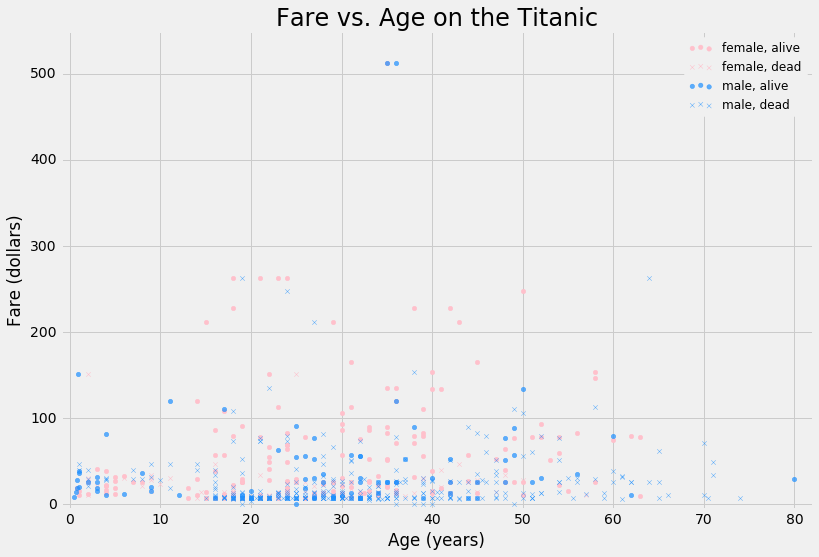

In [31]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

#area = titanic['fare'] 

alive = titanic[titanic['survived'] == 1]
dead = titanic[titanic['survived'] == 0]

alive_females = alive[alive['female'] == 1]
dead_females = dead[dead['female'] == 1]
alive_males = alive[alive['female'] == 0]
dead_males = dead[dead['female'] == 0]


plt.scatter(alive_females['age'], alive_females['fare'], color = 'pink', marker = 'o', \
            label = 'female, alive')
plt.scatter(dead_females['age'], dead_females['fare'], color = 'pink', marker = 'x', \
            label = 'female, dead')
plt.scatter(alive_males['age'], alive_males['fare'], alpha = 0.7, color = 'dodgerblue', \
            marker = 'o', label = 'male, alive')
plt.scatter(dead_males['age'], dead_males['fare'], alpha = 0.7, color = 'dodgerblue', \
            marker = 'x', label = 'male, dead')

plt.title('Fare vs. Age on the Titanic', fontsize = 24)

# y label
plt.ylabel('Fare (dollars)')

# x label
plt.xlabel('Age (years)')

# set the figure boundaries
plt.xlim([-1, 82])
plt.ylim([-5, 550])

plt.legend(fontsize = 12)
plt.grid(True)

plt.show()

Which passengers are paying over $300?

In [32]:
titanic[titanic['fare'] > 300]

,survived,last_name,first_name,female,age,fare,class_1,class_2,class_3,ticket_prefix,...,par_child_dummy,family_dummy,Mr,Mrs,Miss,Master,other_title,C,Q,S
258,1,Ward,Anna,1,35.0,512.33,1,0,0,PC,...,0,0,0,0,1,0,0,1,0,0
679,1,Cardeza,Thomas Drake Martinez,0,36.0,512.33,1,0,0,PC,...,1,1,1,0,0,0,0,1,0,0
737,1,Lesurer,Gustave J,0,35.0,512.33,1,0,0,PC,...,0,0,1,0,0,0,0,1,0,0


They traveled together; maybe $512.33 is total fare?  We could divide by three or just take them out.  Let's remove them, because they are obviously outliers even if fare is correct:

In [33]:
titanic = titanic[titanic['fare'] < 300]

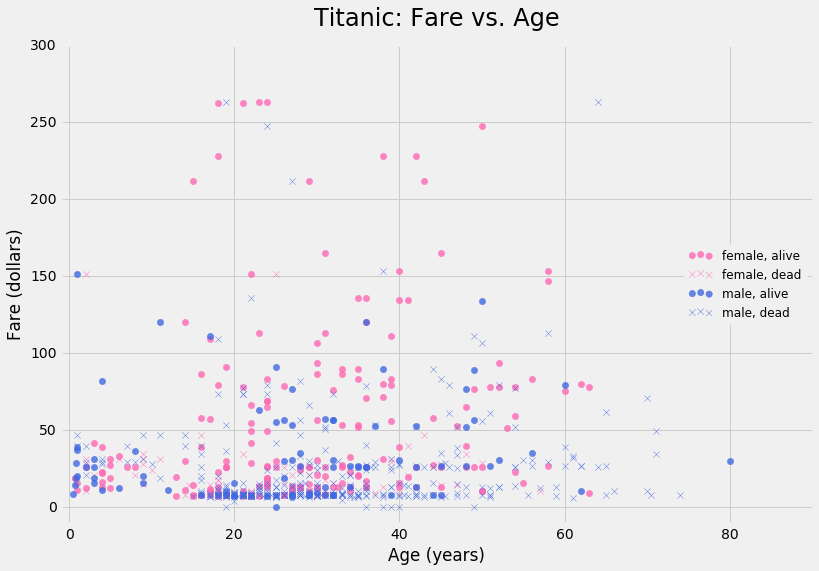

In [64]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

alive = titanic[titanic['survived'] == 1]
dead = titanic[titanic['survived'] == 0]

alive_females = alive[alive['female'] == 1]
dead_females = dead[dead['female'] == 1]
alive_males = alive[alive['female'] == 0]
dead_males = dead[dead['female'] == 0]


plt.scatter(alive_females['age'], alive_females['fare'], color = 'hotpink', \
            marker = 'o', label = 'female, alive', alpha = 0.8, s = 40)
plt.scatter(dead_females['age'], dead_females['fare'], color = 'hotpink', marker = 'x', \
            label = 'female, dead', alpha = 0.8, s = 40)
plt.scatter(alive_males['age'], alive_males['fare'], alpha = 0.8, color = 'royalblue', \
            marker = 'o', label = 'male, alive', s = 40)
plt.scatter(dead_males['age'], dead_males['fare'], alpha = 0.8, color = 'royalblue', \
            marker = 'x', label = 'male, dead', s = 40)

plt.title('Titanic: Fare vs. Age', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Fare (dollars)')

# x label
plt.xlabel('Age (years)')

# set the figure boundaries
plt.xlim([-1, 90])
plt.ylim([-10, 300])

plt.legend(fontsize = 12, loc = 'center right')
plt.grid(True)

del alive
del dead
del alive_females
del dead_females
del alive_males
del dead_males

plt.show()

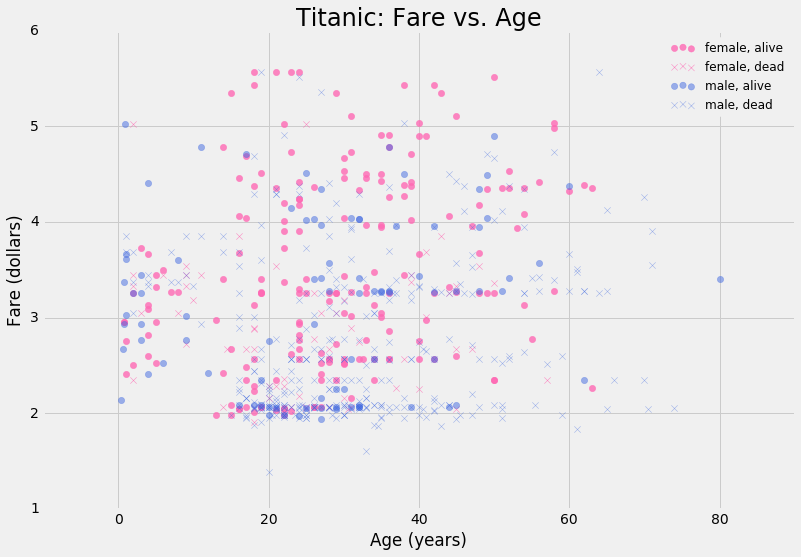

In [56]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

alive = titanic[titanic['survived'] == 1]
dead = titanic[titanic['survived'] == 0]

alive_females = alive[alive['female'] == 1]
dead_females = dead[dead['female'] == 1]
alive_males = alive[alive['female'] == 0]
dead_males = dead[dead['female'] == 0]


plt.scatter(alive_females['age'], np.log(alive_females['fare']), color = 'hotpink', \
            marker = 'o', label = 'female, alive', alpha = 0.8, s = 40)
plt.scatter(dead_females['age'], np.log(dead_females['fare']), color = 'hotpink', \
            marker = 'x', label = 'female, dead', alpha = 0.8, s = 40)
plt.scatter(alive_males['age'], np.log(alive_males['fare']), alpha = 0.5, \
            color = 'royalblue', marker = 'o', label = 'male, alive', s = 40)
plt.scatter(dead_males['age'], np.log(dead_males['fare']), alpha = 0.5, \
            color = 'royalblue', marker = 'x', label = 'male, dead', s = 40)

plt.title('Titanic: Fare vs. Age', fontsize = 24)

# y label
plt.ylabel('Fare (dollars)')

# x label
plt.xlabel('Age (years)')

# set the figure boundaries
# plt.xlim([-1, 82])
# plt.ylim([np.log(-5), np.log(300)])

plt.legend(fontsize = 12)
plt.grid(True)

del alive
del dead
del alive_females
del dead_females
del alive_males
del dead_males

plt.show()

From this scatterplot, we can see for example young males and well-paying females had relatively high survival rates among passengers included in the data.  It looks like most males who paid no fare did not survive.  No females paid no fare.  There were not as many older women as older men, either alive or dead.  The 80 year old man perhaps got helped off because he was so old.  In general, it appears that the proportion of surviving females was higher than that of surviving males.

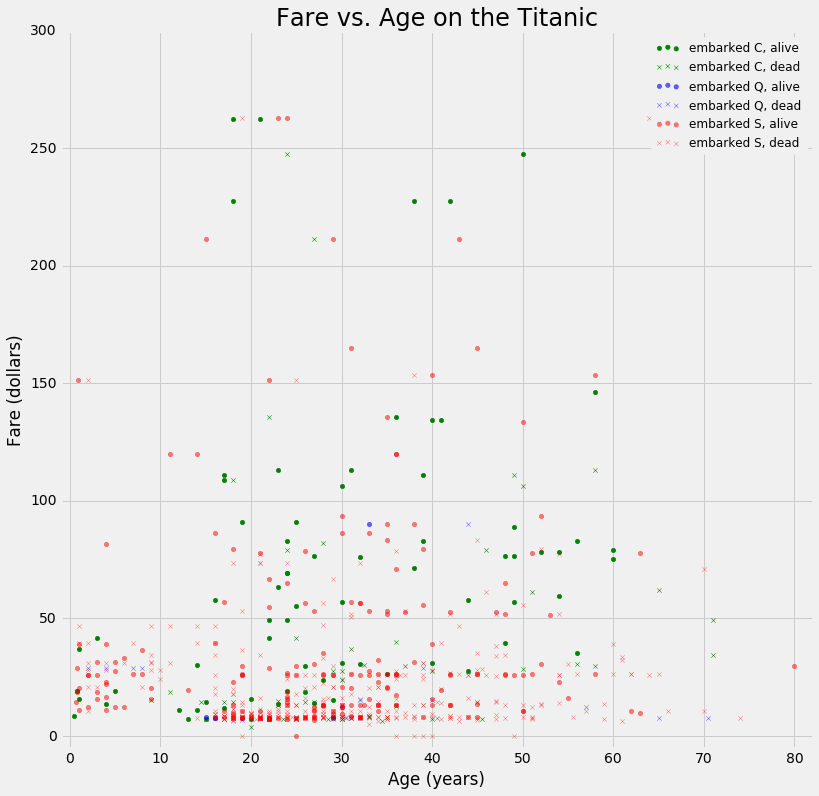

In [65]:
plt.figure(figsize=(12,12))
plt.style.use('fivethirtyeight')

#area = titanic['fare'] 
alive = titanic[titanic['survived'] == 1]
dead = titanic[titanic['survived'] == 0]

alive_C = alive[alive['C'] == 1]
dead_C = dead[dead['C'] == 1]
alive_Q = alive[alive['Q'] == 1]
dead_Q = dead[dead['Q'] == 1]
alive_S = alive[alive['S'] == 1]
dead_S = dead[dead['S'] == 1]


plt.scatter(alive_C['age'], alive_C['fare'], color = 'green', marker = 'o', \
            label = 'embarked C, alive')
plt.scatter(dead_C['age'], dead_C['fare'], color = 'green', marker = 'x', \
            label = 'embarked C, dead')
plt.scatter(alive_Q['age'], alive_Q['fare'], alpha = 0.6, color = 'blue', marker = 'o', \
            label = 'embarked Q, alive')
plt.scatter(dead_Q['age'], dead_Q['fare'], alpha = 0.6, color = 'blue', marker = 'x', \
            label = 'embarked Q, dead')
plt.scatter(alive_S['age'], alive_S['fare'], alpha = 0.5, color = 'red', marker = 'o', \
            label = 'embarked S, alive')
plt.scatter(dead_S['age'], dead_S['fare'], alpha = 0.5, color = 'red', marker = 'x', \
            label = 'embarked S, dead')

plt.title('Fare vs. Age on the Titanic', fontsize = 24)

# y label
plt.ylabel('Fare (dollars)')

# x label
plt.xlabel('Age (years)')

# set the figure boundaries
plt.xlim([-1, 82])
plt.ylim([-5, 300])

plt.legend(fontsize = 12)
plt.grid(True)

plt.show()

Number of passengers who paid no fare:

In [66]:
len(titanic[titanic['fare'] == 0])

15

Examine observations for which we assigned 'ticket_number' value 0:

In [67]:
titanic[titanic['ticket_number'] == 0]

,survived,last_name,first_name,female,age,fare,class_1,class_2,class_3,ticket_prefix,...,par_child_dummy,family_dummy,Mr,Mrs,Miss,Master,other_title,C,Q,S
179,0,Leonard,Lionel,0,36.0,0.0,0,0,1,LINE,...,0,0,1,0,0,0,0,0,0,1
271,1,Tornquist,William Henry,0,25.0,0.0,0,0,1,LINE,...,0,0,1,0,0,0,0,0,0,1
302,0,Johnson,William Cahoone Jr,0,19.0,0.0,0,0,1,LINE,...,0,0,1,0,0,0,0,0,0,1
597,0,Johnson,Alfred,0,49.0,0.0,0,0,1,LINE,...,0,0,1,0,0,0,0,0,0,1


Hm, they all have 'ticket_prefix' assigned to 'LINE', too... let's see how many other observations with that value there are:

In [68]:
titanic[titanic['ticket_prefix'] == 'LINE']

,survived,last_name,first_name,female,age,fare,class_1,class_2,class_3,ticket_prefix,...,par_child_dummy,family_dummy,Mr,Mrs,Miss,Master,other_title,C,Q,S
179,0,Leonard,Lionel,0,36.0,0.0,0,0,1,LINE,...,0,0,1,0,0,0,0,0,0,1
271,1,Tornquist,William Henry,0,25.0,0.0,0,0,1,LINE,...,0,0,1,0,0,0,0,0,0,1
302,0,Johnson,William Cahoone Jr,0,19.0,0.0,0,0,1,LINE,...,0,0,1,0,0,0,0,0,0,1
597,0,Johnson,Alfred,0,49.0,0.0,0,0,1,LINE,...,0,0,1,0,0,0,0,0,0,1


None!  Let's see if mayyyybe we could impute using other information they all have in common:

In [69]:
len(titanic[(titanic['S'] == 1) & (titanic['class_3'] == 1)])

353

In [70]:
del titanic['ticket_number']

Nope!  Too many others, and their ticket prices are all over the place.  Through time travel, we know that ticket number does not end up as a significant feature in our final model; instead of deleting these observations, let's keep them in and un-consider ticket_number.

### Make the model

Run logistic regression without 'age' feature first, since it has a lot of 'nan' and we'll wait to remove them; also, let's run without cabin info since it's missing for so many observations:

In [71]:
titanic.columns

Index([u'survived', u'last_name', u'first_name', u'female', u'age', u'fare',
       u'class_1', u'class_2', u'class_3', u'ticket_prefix', u'cabin_section',
       u'cabin_number', u'sibling_dummy', u'par_child_dummy', u'family_dummy',
       u'Mr', u'Mrs', u'Miss', u'Master', u'other_title', u'C', u'Q', u'S'],
      dtype='object')

In [73]:
titanic_prescale = titanic[['survived', 'female', 'fare', 'class_1', 'class_2', 'class_3', \
                            'sibling_dummy', 'par_child_dummy', 'family_dummy', 'Mr', 'Mrs', \
                            'Miss', 'Master', 'C', 'Q', 'S']]

titanic_scaled = preprocessing.scale(titanic_prescale)
titanic_scaled = pd.DataFrame(titanic_scaled)
titanic_scaled.columns = ['survived', 'female', 'fare', 'class_1', 'class_2', 'class_3', \
                          'sibling_dummy', 'par_child_dummy', 'family_dummy', 'Mr', 'Mrs', \
                          'Miss', 'Master', 'C', 'Q', 'S']
titanic_scaled.head()

,survived,female,fare,class_1,class_2,class_3,sibling_dummy,par_child_dummy,family_dummy,Mr,Mrs,Miss,Master,C,Q,S
0,-0.785803,-0.737799,-0.566959,-0.561743,-0.511237,0.899196,1.462125,-0.560008,1.231089,0.851042,-0.408516,-0.509485,-0.217186,-0.477719,-0.308131,0.615534
1,1.272584,1.355382,0.988930,1.780172,-0.511237,-1.112104,1.462125,-0.560008,1.231089,-1.175031,2.447882,-0.509485,-0.217186,2.093279,-0.308131,-1.624606
2,1.272584,1.355382,-0.550678,-0.561743,-0.511237,0.899196,-0.683936,-0.560008,-0.812289,-1.175031,-0.408516,1.962768,-0.217186,-0.477719,-0.308131,0.615534
3,1.272584,1.355382,0.547167,1.780172,-0.511237,-1.112104,1.462125,-0.560008,1.231089,-1.175031,2.447882,-0.509485,-0.217186,-0.477719,-0.308131,0.615534
4,-0.785803,-0.737799,-0.547519,-0.561743,-0.511237,0.899196,-0.683936,-0.560008,-0.812289,0.851042,-0.408516,-0.509485,-0.217186,-0.477719,-0.308131,0.615534


In [74]:
X = titanic_scaled[['survived', 'female', 'fare', 'class_1', 'class_2', 'class_3', \
                 'sibling_dummy', 'par_child_dummy', 'family_dummy', 'Mr', 'Miss', 'Mrs', \
                 'Master', 'C', 'Q', 'S']]
y = titanic_scaled['survived']
X.cov()

,survived,female,fare,class_1,class_2,class_3,sibling_dummy,par_child_dummy,family_dummy,Mr,Miss,Mrs,Master,C,Q,S
survived,1.001127,0.546515,0.262032,0.280896,0.095942,-0.319453,0.119339,0.147341,0.205039,-0.552946,0.333549,0.348114,0.086487,0.161151,0.004987,-0.149984
female,0.546515,1.001127,0.222607,0.099049,0.064886,-0.137960,0.203835,0.250617,0.306564,-0.867914,0.691325,0.554320,-0.160420,0.083977,0.074291,-0.126849
fare,0.262032,0.222607,1.001127,0.649679,-0.123373,-0.457389,0.259762,0.279555,0.334678,-0.229684,0.134175,0.144032,0.021774,0.245755,-0.129722,-0.138418
class_1,0.280896,0.099049,0.649679,1.001127,-0.287508,-0.625421,0.062998,0.007114,0.115064,-0.099126,0.020266,0.094551,-0.083950,0.287968,-0.154521,-0.162491
class_2,0.095942,0.064886,-0.123373,-0.287508,1.001127,-0.569190,0.031999,0.039619,0.038968,-0.088547,-0.026950,0.124620,0.009545,-0.122928,-0.128052,0.190415
class_3,-0.319453,-0.137960,-0.457389,-0.625421,-0.569190,1.001127,-0.080189,-0.038407,-0.130586,0.157315,0.004564,-0.182792,0.064317,-0.147104,0.237094,-0.015674
sibling_dummy,0.119339,0.203835,0.259762,0.062998,0.031999,-0.080189,1.001127,0.422453,0.842936,-0.294744,0.004062,0.273161,0.247918,0.039907,-0.056223,0.004126
par_child_dummy,0.147341,0.250617,0.279555,0.007114,0.039619,-0.038407,0.422453,1.001127,0.690198,-0.385511,0.132791,0.193984,0.375513,0.031331,-0.097572,0.037039
family_dummy,0.205039,0.306564,0.334678,0.115064,0.038968,-0.130586,0.842936,0.690198,1.001127,-0.400113,0.052701,0.358721,0.267677,0.097186,-0.086849,-0.025826
Mr,-0.552946,-0.867914,-0.229684,-0.099126,-0.088547,0.157315,-0.294744,-0.385511,-0.400113,1.001127,-0.599335,-0.480561,-0.255488,-0.074539,-0.078381,0.120293


In [75]:
lil_X_prescale = X[['female', 'Mr', 'Mrs', 'Miss', 'Master']]
lil_X_scaled = preprocessing.scale(lil_X_prescale)
lil_X_scaled = pd.DataFrame(lil_X_scaled)
lil_X_scaled.columns = ['female', 'Mr', 'Mrs', 'Miss', 'Master']
lil_X_scaled.head()
lil_X_scaled.cov()

,female,Mr,Mrs,Miss,Master
female,1.001127,-0.867914,0.554320,0.691325,-0.160420
Mr,-0.867914,1.001127,-0.480561,-0.599335,-0.255488
Mrs,0.554320,-0.480561,1.001127,-0.208367,-0.088824
Miss,0.691325,-0.599335,-0.208367,1.001127,-0.110778
Master,-0.160420,-0.255488,-0.088824,-0.110778,1.001127


We'll be careful with these, since they're obviously collinear!

In [91]:
# leave out titanic['other_title'] since we don't want to use dummies whose union \
# spans all observations
X_title = titanic[['Mr', 'Miss', 'Mrs', 'Master']]
X_title['intercept'] = 1
y = titanic['survived']

model_title = st.MNLogit(y, X_title)

model_title_fit = model_title.fit(method = 'bfgs')

model_title_fit.summary()

         Current function value: 0.494469
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Rebecca/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               survived   No. Observations:                  888
Model:                        MNLogit   Df Residuals:                      883
Method:                           MLE   Df Model:                            4
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:                  0.2563
Time:                        03:00:55   Log-Likelihood:                -439.09
converged:                      False   LL-Null:                       -590.45
                                        LLR p-value:                 2.811e-64
==============================================================================
survived=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Mr            -1.0788      0.455     -2.373      0.018        -1.970    -0.188
Miss           1.4741      0.467      3.159      0.002         0.560     2.389
Mrs            1.9863      0.490      4.054      0.000         1.026     2.947
Master         0.9332      0.542      1.721      0.085        -0.130     1.996
intercept     -0.6294      0.438     -1.438      0.151        -1.488     0.229
==============================================================================
"""

In [92]:
print 'Title model (\'other_title\' left out)'
print 'AIC: %s' %model_title_fit.aic
print 'BIC: %s' %model_title_fit.bic

Title model ('other_title' left out)
AIC: 888.177358624
BIC: 912.122217339


Let's redo this model without 'Master', since at 0.05 level it is not significant in predicting survival:

In [93]:
X_title = titanic[['Mr', 'Miss', 'Mrs']]
X_title['intercept'] = 1
y = titanic['survived']

model_title = st.MNLogit(y, X_title)

model_title_fit = model_title.fit(method = 'bfgs')

model_title_fit.summary()

Optimization terminated successfully.
         Current function value: 0.496188
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               survived   No. Observations:                  888
Model:                        MNLogit   Df Residuals:                      884
Method:                           MLE   Df Model:                            3
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:                  0.2538
Time:                        03:01:13   Log-Likelihood:                -440.61
converged:                       True   LL-Null:                       -590.45
                                        LLR p-value:                 1.176e-64
==============================================================================
survived=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Mr            -1.6760      0.280     -5.983      0.000        -2.225    -1.127
Miss           0.8768      0.299      2.931      0.003         0.290     1.463
Mrs            1.3892      0.334      4.153      0.000         0.734     2.045
intercept     -0.0321      0.252     -0.128      0.899        -0.526     0.462
==============================================================================
"""

In [94]:
print 'Title model (\'Master\' and \'other\' left out)'
print 'AIC: %s' %model_title_fit.aic
print 'BIC: %s' %model_title_fit.bic

Title model ('Master' and 'other' left out)
AIC: 889.229474187
BIC: 908.385361159


From this model, let's keep 'Mr', 'Miss', and 'Mrs' dummy features since they're all significant at a 0.05 level.

In [95]:
X_female = titanic[['female']]
X_female['intercept'] = 1
y = titanic['survived']

model_female = st.MNLogit(y, X_female)

model_female_fit = model_female.fit()

model_female_fit.summary()

Optimization terminated successfully.
         Current function value: 0.512675
         Iterations 5


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               survived   No. Observations:                  888
Model:                        MNLogit   Df Residuals:                      886
Method:                           MLE   Df Model:                            1
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:                  0.2290
Time:                        03:01:17   Log-Likelihood:                -455.26
converged:                       True   LL-Null:                       -590.45
                                        LLR p-value:                 9.361e-61
==============================================================================
survived=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
female         2.5279      0.168     15.070      0.000         2.199     2.857
intercept     -1.4756      0.107    -13.771      0.000        -1.686    -1.266
==============================================================================
"""

In [96]:
print 'Title model (\'Master\' and \'other\' left out)'
print 'AIC: %s' %model_female_fit.aic
print 'BIC: %s' %model_female_fit.bic

Title model ('Master' and 'other' left out)
AIC: 914.510145131
BIC: 924.088088617


Try 'fare' as a sole model feature:

In [97]:
X_fare = titanic[['fare']]
X_fare['intercept'] = 1
y = titanic['survived']

model_fare = st.MNLogit(y, X_fare)

model_fare_fit = model_fare.fit()

model_fare_fit.summary()

Optimization terminated successfully.
         Current function value: 0.629260
         Iterations 5


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               survived   No. Observations:                  888
Model:                        MNLogit   Df Residuals:                      886
Method:                           MLE   Df Model:                            1
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:                 0.05363
Time:                        03:01:23   Log-Likelihood:                -558.78
converged:                       True   LL-Null:                       -590.45
                                        LLR p-value:                 1.749e-15
==============================================================================
survived=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
fare           0.0152      0.002      6.794      0.000         0.011     0.020
intercept     -0.9411      0.095     -9.887      0.000        -1.128    -0.755
==============================================================================
"""

In [98]:
print 'Fare model'
print 'AIC: %s' %model_fare_fit.aic
print 'BIC: %s' %model_fare_fit.bic

Fare model
AIC: 1121.56500505
BIC: 1131.14294853


Let's keep 'fare' since it's significant at a 0.05 level.

In [99]:
# leave out titanic['class_1'] 
X_class = titanic[['class_2', 'class_3']]
X_class['intercept'] = 1
y = titanic['survived']

model_class = st.MNLogit(y, X_class)

model_class_fit = model_class.fit(method = 'bfgs')

model_class_fit.summary()

Optimization terminated successfully.
         Current function value: 0.608281
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               survived   No. Observations:                  888
Model:                        MNLogit   Df Residuals:                      885
Method:                           MLE   Df Model:                            2
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:                 0.08518
Time:                        03:01:30   Log-Likelihood:                -540.15
converged:                       True   LL-Null:                       -590.45
                                        LLR p-value:                 1.439e-22
==============================================================================
survived=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
class_2       -0.6172      0.205     -3.018      0.003        -1.018    -0.216
class_3       -1.6482      0.176     -9.345      0.000        -1.994    -1.303
intercept      0.5084      0.141      3.593      0.000         0.231     0.786
==============================================================================
"""

In [100]:
print 'Class model'
print 'AIC: %s' %model_class_fit.aic
print 'BIC: %s' %model_class_fit.bic

Class model
AIC: 1086.3074644
BIC: 1100.67437963


Let's keep the class dummy variables since they're significant at a 0.05 level.

In [101]:
titanic.columns

Index([u'survived', u'last_name', u'first_name', u'female', u'age', u'fare',
       u'class_1', u'class_2', u'class_3', u'ticket_prefix', u'cabin_section',
       u'cabin_number', u'sibling_dummy', u'par_child_dummy', u'family_dummy',
       u'Mr', u'Mrs', u'Miss', u'Master', u'other_title', u'C', u'Q', u'S'],
      dtype='object')

In [102]:
# leave out titanic['S']
X_embark = titanic[['Q', 'S']]
X_embark['intercept'] = 1
y = titanic['survived']

model_embark = st.MNLogit(y, X_embark)

model_embark_fit = model_embark.fit()

model_embark_fit.summary()

Optimization terminated successfully.
         Current function value: 0.650769
         Iterations 4


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               survived   No. Observations:                  888
Model:                        MNLogit   Df Residuals:                      885
Method:                           MLE   Df Model:                            2
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:                 0.02128
Time:                        03:01:35   Log-Likelihood:                -577.88
converged:                       True   LL-Null:                       -590.45
                                        LLR p-value:                 3.494e-06
==============================================================================
survived=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Q             -0.6533      0.281     -2.327      0.020        -1.203    -0.103
S             -0.8812      0.177     -4.992      0.000        -1.227    -0.535
intercept      0.2043      0.156      1.313      0.189        -0.101     0.509
==============================================================================
"""

In [103]:
print 'Embarcation dummy model'
print 'AIC: %s' %model_embark_fit.aic
print 'BIC: %s' %model_embark_fit.bic

Embarcation dummy model
AIC: 1161.76489613
BIC: 1176.13181136


In [104]:
X_sibling = titanic[['sibling_dummy']]
X_sibling['intercept'] = 1
X_par_child = titanic[['par_child_dummy']]
X_par_child['intercept'] = 1
X_family = titanic[['family_dummy']]
X_family['intercept'] = 1
X_sibpar = titanic[['sibling_dummy', 'par_child_dummy']]
X_sibpar['intercept'] = 1

y = titanic['survived']
model_sibling = st.MNLogit(y, X_sibling)
model_sibling_fit = model_sibling.fit()
model_par_child = st.MNLogit(y, X_par_child)
model_par_child_fit = model_par_child.fit()
model_family = st.MNLogit(y, X_family)
model_family_fit = model_family.fit()
model_sibpar = st.MNLogit(y, X_sibpar)
model_sibpar_fit = model_sibpar.fit()

print '\n'
print 'sibling dummy model'
print 'AIC: %s' %model_sibling_fit.aic
print 'BIC: %s' %model_sibling_fit.bic
print '\n'
print 'parent - child dummy model'
print 'AIC: %s' %model_par_child_fit.aic
print 'BIC: %s' %model_par_child_fit.bic
print '\n'
print 'family dummy model'
print 'AIC: %s' %model_family_fit.aic
print 'BIC: %s' %model_family_fit.bic
print '\n'
print 'sibling-parchild dummy model'
print 'AIC: %s' %model_sibpar_fit.aic
print 'BIC: %s' %model_sibpar_fit.bic

Optimization terminated successfully.
         Current function value: 0.657888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


sibling dummy model
AIC: 1172.40978338
BIC: 1181.98772687


parent - child dummy model
AIC: 1166.0288738
BIC: 1175.60681729


family dummy model
AIC: 1147.80629061
BIC: 1157.38423409


sibling-parchild dummy model
AIC: 1164.49093083
BIC: 1178.85784606


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Keep the 'family_dummy' feature since it has the lowest AIC.

In [106]:
X_big = titanic[['female', 'fare', 'class_2', 'class_3', 'Q', 'S', 'family_dummy']]
X_big['intercept'] = 1

y = titanic['survived']

model_big = st.MNLogit(y, X_big)

model_big_fit = model_big.fit()

model_big_fit.summary()

Optimization terminated successfully.
         Current function value: 0.458953
         Iterations 6


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               survived   No. Observations:                  888
Model:                        MNLogit   Df Residuals:                      880
Method:                           MLE   Df Model:                            7
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:                  0.3098
Time:                        03:02:18   Log-Likelihood:                -407.55
converged:                       True   LL-Null:                       -590.45
                                        LLR p-value:                 5.114e-75
================================================================================
  survived=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
female           2.6000      0.194     13.413      0.000         2.220     2.980
fare            -0.0022      0.003     -0.759      0.448        -0.008     0.004
class_2         -0.7571      0.291     -2.605      0.009        -1.327    -0.187
class_3         -1.9401      0.280     -6.932      0.000        -2.489    -1.392
Q               -0.1006      0.368     -0.274      0.784        -0.821     0.620
S               -0.5686      0.230     -2.473      0.013        -1.019    -0.118
family_dummy     0.1454      0.197      0.737      0.461        -0.241     0.532
intercept        0.0815      0.300      0.271      0.786        -0.507     0.670
================================================================================
"""

In [107]:
print 'Big model'
print 'AIC: %s' %model_big_fit.aic
print 'BIC: %s' %model_big_fit.bic

Big model
AIC: 831.099911855
BIC: 869.411685799


In [108]:
X_lessbig = titanic[['female', 'class_2', 'class_3', 'S']]

X_lessbig['intercept'] = 1

y = titanic['survived']

model_lessbig = st.MNLogit(y, X_lessbig)

model_lessbig_fit = model_lessbig.fit()

model_lessbig_fit.summary()

Optimization terminated successfully.
         Current function value: 0.459480
         Iterations 6


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               survived   No. Observations:                  888
Model:                        MNLogit   Df Residuals:                      883
Method:                           MLE   Df Model:                            4
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:                  0.3090
Time:                        03:02:32   Log-Likelihood:                -408.02
converged:                       True   LL-Null:                       -590.45
                                        LLR p-value:                 1.085e-77
==============================================================================
survived=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
female         2.6125      0.185     14.131      0.000         2.250     2.975
class_2       -0.6628      0.251     -2.640      0.008        -1.155    -0.171
class_3       -1.8415      0.216     -8.512      0.000        -2.265    -1.417
S             -0.5258      0.197     -2.668      0.008        -0.912    -0.140
intercept     -0.0406      0.212     -0.192      0.848        -0.456     0.375
==============================================================================
"""

In [109]:
print 'Less big model'
print 'AIC: %s' %model_lessbig_fit.aic
print 'BIC: %s' %model_lessbig_fit.bic

Less big model
AIC: 826.035871423
BIC: 849.980730138


In [110]:
skl_model = lm.LogisticRegression()
X_scaled = preprocessing.scale(X_lessbig)
X_scaled = pd.DataFrame(X_scaled)
X_scaled['intercept'] = 1
#X_scaled = X_scaled.reset_index(drop = True)
y = titanic['survived']
#y = y.reset_index(drop = True)

skl_model.fit(X_scaled, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [111]:
X_scaled['probability'] = skl_model.predict_proba(X_scaled).T[1]
X_scaled.columns = ['female', 'class_2', 'class_3', 'S', \
                   'unclear', 'intercept', 'probability']
X_scaled = X_scaled[['female', 'class_2', 'class_3', 'S', \
                   'unclear', 'intercept', 'probability']]
X_scaled.head()

,female,class_2,class_3,S,unclear,intercept,probability
0,-0.737799,-0.511237,0.899196,0.615534,0.0,1,0.084461
1,1.355382,-0.511237,-1.112104,-1.624606,0.0,1,0.926683
2,1.355382,-0.511237,0.899196,0.615534,0.0,1,0.550599
3,1.355382,-0.511237,-1.112104,0.615534,0.0,1,0.882200
4,-0.737799,-0.511237,0.899196,0.615534,0.0,1,0.084461


In [112]:
predictions = skl_model.predict(X_scaled[['female', 'class_2', 'class_3', 'S', 'unclear', \
                                          'intercept']])

cm = confusion_matrix(y, predictions)
cm

array([[468,  81],
       [107, 232]])

In [113]:
sum(predictions)

313

In [123]:
def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], \
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels, rotation = 90)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, \
                            foreground='black'), path_effects.Normal()])
    return

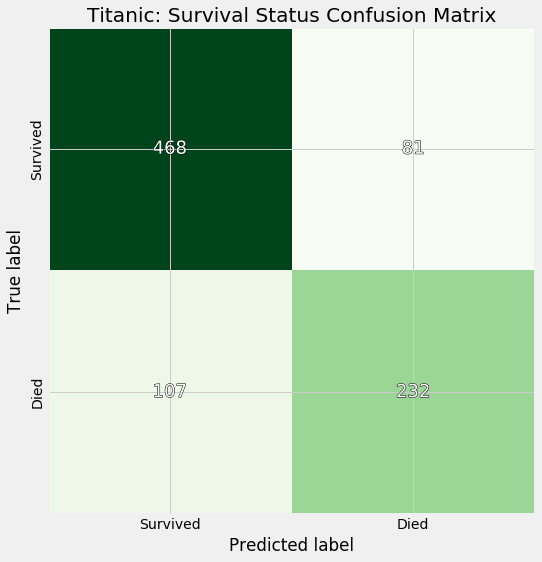

In [124]:
plot_confusion_matrix(cm, title='Titanic: Survival Status Confusion Matrix', \
                      labels=['Survived', 'Died'], cmap=plt.cm.Greens)

In [125]:
roc = roc_curve(y, predictions)
roc

(array([ 0.        ,  0.14754098,  1.        ]),
 array([ 0.        ,  0.68436578,  1.        ]),
 array([2, 1, 0]))

In [98]:
pred1 = skl_model.predict_proba(X_scaled[['female', 'class_2', 'class_3', 'S', 'unclear', \
                                          'intercept']]).T[1]
roc = roc_curve(y, pred1)

In [128]:
def getROCcurve(roc, title='ROC Curve', xlabel='% False Positives', ylabel='% True Positives'):
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 0.4, color = 'magenta')
    return

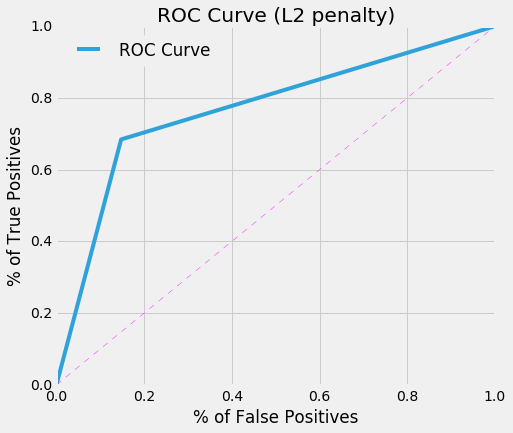

In [129]:
getROCcurve(roc, title='ROC Curve (L2 penalty)', xlabel ='% of False Positives', \
            ylabel = '% of True Positives')

In [130]:
cross_val_score(skl_model, X_scaled[['female', 'class_2', 'class_3', 'S', 'unclear', \
                                     'intercept']], y, n_jobs=1, cv=5)

array([ 0.76404494,  0.78651685,  0.78651685,  0.75842697,  0.78977273])

In [131]:
score = cross_val_score(skl_model, X_scaled[['female', 'class_2', 'class_3', 'S', 'unclear', \
                                             'intercept']], \
                        y, n_jobs=1, cv=5).mean()

print 'R^2: %s' %score

R^2: 0.77705566905


In [132]:
print 'accuracy: %s' %accuracy_score(y, predictions) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y, predictions) # TP / P
print 'recall: %s' %recall_score(y, predictions) # TP / (TP + FN)
print 'area under curve: %s' %roc_auc_score(y, predictions)

accuracy: 0.788288288288
precision: 0.741214057508
recall: 0.684365781711
area under curve: 0.768412399052
